<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Modeltf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install joblib
import tensorflow as tf 
import pickle
from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math

from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow


In [0]:
from google.colab import drive
drive.mount('/content/drive')


In [0]:
## 64 BIT (2253,4016)
import pickle
with open('/content/drive/My Drive/ffeatures64.bin','rb') as file:
  features = pickle.load(file)
with open('/content/drive/My Drive/flabels64.bin','rb') as file:
  labels = pickle.load(file)


In [0]:
## 48 BIT (2253,2315)
'''
features = joblib.load('/content/features48.pkl')
labels = joblib.load('/content/labels48.pkl')
'''

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## 56 BIT (2253,3147)

# features = joblib.load('/content/features56.pkl')
# labels = joblib.load('/content/labels56.pkl')


In [0]:
## 64 BIT (2253,3147)

features = joblib.load('/content/features64.pkl')
labels = joblib.load('/content/labels64.pkl')


In [0]:
## 32 BIT (2253,1035)

# features = joblib.load('/content/features32.pkl')
# labels = joblib.load('/content/labels32.pkl')

In [0]:
## 16 BIT (2253,267)
'''
features = joblib.load('/content/features16.pkl')
labels = joblib.load('/content/labels16.pkl')
'''

"\nfeatures = joblib.load('/content/features16.pkl')\nlabels = joblib.load('/content/labels16.pkl')\n"

In [0]:
# print(features[0])
# print(len(features[0]))
# print(len(features))
print(np.shape(features))

(2253, 4106)


In [0]:
## TEST SET 

x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(features, labels, test_size = 0.3)

In [0]:
tf.reset_default_graph()

In [0]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1120482715673100208
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16058177477353962571
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11827516184072269378
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892276122
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4363692627500606216
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
x = tf.placeholder(shape = (None,4106), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,1), dtype = tf.float32, name = 'target')

wh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((4106, 4500)))
bh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,4500)))

#out

wo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((4500,1)))
bo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,1)))


In [0]:
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
model = Sequential()
model.add(Dense(4500, input_shape = (4106, ), activation = 'relu') )
model.add(Dense(5000, activation = 'relu') )
model.add(Dense(2000, activation = 'relu') )

# model.add(BatchNormalization(axis = -1))
# model.add(Dropout(0.5))
model.add(Dense(1,  activation = 'relu'))

In [0]:
model.compile(optimizer = Adam(lr = 0.001), loss = 'mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4500)              18481500  
_________________________________________________________________
dense_7 (Dense)              (None, 5000)              22505000  
_________________________________________________________________
dense_8 (Dense)              (None, 2000)              10002000  
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 2001      
Total params: 50,990,501
Trainable params: 50,990,501
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist = model.fit(features, labels, validation_split = 0.33, epochs = 300, verbose = 1, batch_size = 32, shuffle = True)

Train on 1509 samples, validate on 744 samples
Epoch 1/300
1509/1509 [==============================] - 5s 3ms/step - loss: 2676.0874 - val_loss: 95.7514
Epoch 2/300
1509/1509 [==============================] - 3s 2ms/step - loss: 921.6374 - val_loss: 147.2297
Epoch 3/300
1509/1509 [==============================] - 3s 2ms/step - loss: 871.7196 - val_loss: 149.1551
Epoch 4/300
1509/1509 [==============================] - 3s 2ms/step - loss: 741.4219 - val_loss: 455.6195
Epoch 5/300
1509/1509 [==============================] - 3s 2ms/step - loss: 735.2200 - val_loss: 261.8901
Epoch 6/300
1509/1509 [==============================] - 3s 2ms/step - loss: 793.8920 - val_loss: 531.9477
Epoch 7/300
1509/1509 [==============================] - 3s 2ms/step - loss: 683.3074 - val_loss: 309.0732
Epoch 8/300
1509/1509 [==============================] - 3s 2ms/step - loss: 726.8051 - val_loss: 386.9937
Epoch 9/300
1509/1509 [==============================] - 3s 2ms/step - loss: 645.4105 - val_loss:

KeyboardInterrupt: ignored

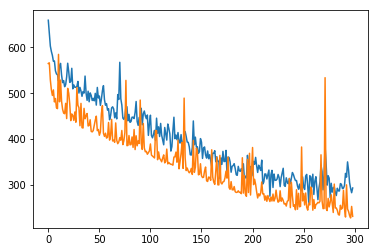

In [0]:
tr = hist.history['loss']
val_ls = hist.history['val_loss']
plt.plot(tr[1:])
plt.plot(val_ls[1:])

In [0]:
hidl = tf.add(tf.matmul(x,wh),bh, name ='hidden1')

In [0]:
outl_batch = tf.compat.v1.layers.batch_normalization(hidl)
outl = tf.add(tf.matmul(outl_batch,wo),bo,name = 'output')


Add additional custom loss functions if necc 
reducing mean sqaure error 
1. reducing max deviation 

In [0]:
loss = tf.reduce_mean(tf.square(tf.subtract(y,outl))) + 0.4*tf.reduce_max(tf.subtract(y,outl))
#default lr = 0.001
opt = tf.train.AdamOptimizer(name = 'optimizer')
op_train = opt.minimize(loss, name ='train_op')



In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

2253.2236	48997.246
50704.285	3389.9448
4077.3252	9268.293
10366.35	25626.137
26427.88	20804.924
21323.047	6026.834
6894.2993	278.37894
247.76566	4668.3223
4090.7866	10641.783
11250.557	11425.7
10375.561	7866.26
6761.7583	3451.7126
3522.0852	1720.345
554.8616	1473.1025
668.62067	2345.5005
3672.5322	3354.2153
5140.0005	3333.448
4238.5513	2875.7844
2938.3767	2603.9263
2929.7095	1168.8499
1129.5686	1300.8322
943.7943	735.4078
1522.443	454.35022
548.7088	1245.1311
806.40674	915.476
1240.0684	1410.5305
1535.4242	1875.3032
1705.5651	950.1401
1187.6006	1337.1451
1055.2029	698.87524
885.4859	803.19354
230.13051	523.2086
247.5114	212.03984
245.94102	802.8298
2082.031	299.4231
966.39014	1182.0715
705.56726	736.83374
1077.3954	2893.011
392.9342	276.19263
625.90753	743.4271
209.20525	999.5697
1212.0728	973.7347
290.11078	195.56523
248.76114	667.59186
378.2094	496.1236
350.74063	566.8336
1285.7609	388.13934
443.2657	352.0076
954.46844	536.3783
748.9122	462.24936
1133.6128	413.35483
823.9844	599.192

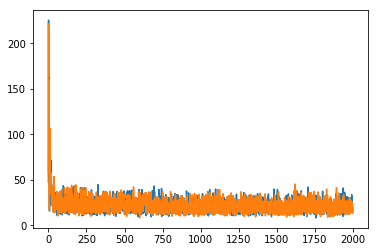

In [0]:
train=[]
val=[]

with tf.device('/device:CPU:0'):
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    mini =[]
    for i in range(0,2000):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
      #TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
      z= sess.run([loss,op_train, update_ops], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0]**0.5)
      
      ##VALIDATION LOSS
      
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0]**0.5)
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    plt.plot(train)
    plt.plot(val)
    
    model = simple_save(sess,'/content/drive/My Drive/Custom_Models/2000',inputs = {'input' : x}, outputs = {'output': outl})
    print('Saved model!')
    
 

In [0]:
with open('/content/drive/My Drive/Custom_Models/graph1000_64updhidden.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())

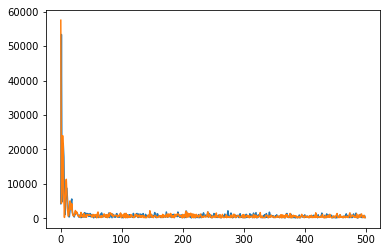

In [0]:
plt.plot(train[1:])
plt.plot(val[1:])

In [0]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(4106, 6500) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(1, 6500) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(6500, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/gamma:0' shape=(6500,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/beta:0' shape=(6500,) dtype=float32_ref>]